## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


In [86]:
import torch
torch.cuda.empty_cache()
print(torch.cuda.is_available())  # Should be True
print(torch.version.cuda)         # Should show a version, e.g., '12.1'

True
12.4


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [87]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from models import Net

net = Net()
net.apply(init_weights)
net.to(device)
print(net)

Using device: cuda
flattened_size: 25088
Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.0, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.0, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.0, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [90]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomRotate, RandomHorizontalFlip, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([
                               RandomHorizontalFlip(0.5),
                               RandomRotate(10),
                               Rescale((240,240)),
                               RandomCrop(224),
                               Normalize(),
                               ToTensor()])      

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [91]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [92]:
# load training data in batches
batch_size = 256

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=16)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [93]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test datasetb
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',
                                      transform=data_transform)

In [94]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [95]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].to(device)
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [96]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [97]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

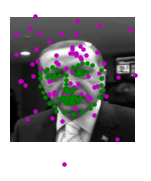

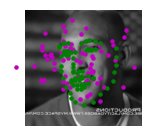

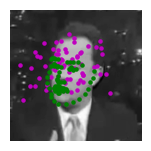

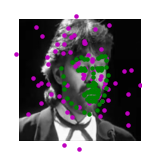

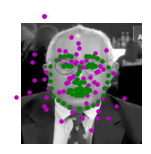

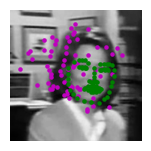

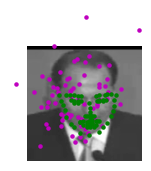

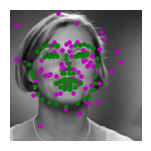

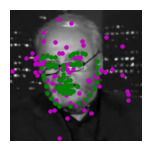

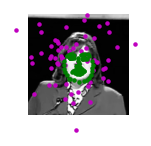

In [98]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        
        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.cpu()
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        #show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        #show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        #show_all_keypoints(
        #    np.squeeze(image.cpu().numpy()), 
        #    predicted_key_pts.cpu().numpy(), 
        #    ground_truth_pts.cpu().numpy() if ground_truth_pts is not None else None
        #)
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy()
        image = np.squeeze(image)

        if isinstance(predicted_key_pts, torch.Tensor):
            predicted_key_pts = predicted_key_pts.cpu().numpy()

        if isinstance(ground_truth_pts, torch.Tensor):
            ground_truth_pts = ground_truth_pts.cpu().numpy()

        show_all_keypoints(image, predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](https://pytorch.org/docs/master/nn.html#loss-functions).

Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [99]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()
#criterion = nn.L1Loss()
#criterion = nn.SmoothL1Loss() 

optimizer = optim.Adam(net.parameters(), lr=0.01)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

### Divide training data into training set and validation set

In [100]:
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(transformed_dataset))  # 80% training
val_size = len(transformed_dataset) - train_size  # 20% validation

train_dataset, val_dataset = random_split(transformed_dataset, [train_size, val_size])
print("training dataset:", len(train_dataset))
print("validation dataset:", len(val_dataset))

training dataset: 2769
validation dataset: 693


In [101]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=16)

In [102]:
# load test data in batches
batch_size = 256

val_loader = DataLoader(val_dataset, 
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=16)

In [103]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            
reset_weights(net)

In [107]:
model_dir = 'saved_models/'
model_name_best_val = 'keypoints_model_3.0.pt'

best_epoch_loss = float('inf')
best_batch_loss = float('inf')
best_val_loss = float('inf')  #

In [108]:
def evaluate_net(net, data_loader, criterion, device):
    """
    Evaluate the network on the provided data loader and return average loss.

    Args:
        net (torch.nn.Module): The model to evaluate.
        data_loader (DataLoader): DataLoader for validation or test data.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to perform computation on.

    Returns:
        float: Average loss over the data_loader.
    """
    net.eval()
    running_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for data in data_loader:
            images = data['image'].to(device)
            key_pts = data['keypoints'].to(device)

            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            output_pts = net(images)
            loss = criterion(output_pts, key_pts)

            running_loss += loss.item()
            num_batches += 1

    average_loss = running_loss / num_batches
    return average_loss

In [109]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Scheduler that reduces LR if val loss doesn't improve
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    
def train_net(n_epochs):
    global best_val_loss
    global model_dir
    global model_name_best_val

    train_batch_losses = []
    train_epoch_losses = []
    val_epoch_losses = []
    
    

    for epoch in range(n_epochs):
        net.train()
        running_loss = 0.0
        num_batches = 0
        interval_loss = 0.0
        interval_batches = 0

        for batch_i, data in enumerate(train_loader):
            images = data['image'].to(device)
            key_pts = data['keypoints'].to(device)

            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            output_pts = net(images)
            loss = criterion(output_pts, key_pts)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            train_batch_losses.append(batch_loss)

            interval_loss += batch_loss
            interval_batches += 1
            running_loss += batch_loss
            num_batches += 1

            if (batch_i + 1) % 5 == 0:
                avg_interval_loss = interval_loss / interval_batches
                interval_loss = 0.0
                interval_batches = 0

        epoch_train_loss = running_loss / num_batches
        train_epoch_losses.append(epoch_train_loss)

        #print(f"Epoch {epoch + 1} — Train Loss: {epoch_train_loss:.6f}")

        # ---------- Validation ----------
        net.eval()
        val_running_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for val_data in val_loader:
                images = val_data['image'].to(device)
                key_pts = val_data['keypoints'].to(device)

                key_pts = key_pts.view(key_pts.size(0), -1)
                key_pts = key_pts.type(torch.cuda.FloatTensor)
                images = images.type(torch.cuda.FloatTensor)

                output_pts = net(images)
                loss = criterion(output_pts, key_pts)

                val_running_loss += loss.item()
                val_batches += 1

        epoch_val_loss = val_running_loss / val_batches
        val_epoch_losses.append(epoch_val_loss)
        
        scheduler.step(epoch_val_loss)

        #print(f"Epoch {epoch + 1} — Val   Loss: {epoch_val_loss:.6f}")
        print(f"Epoch {epoch + 1} — Train Loss: [{epoch_train_loss:.6f}], Validation Loss: [{epoch_val_loss:.6f}], lr:", scheduler.get_last_lr())
        
        lr_min = 1e-6
        if scheduler.get_last_lr()[0] < lr_min:
            print(f"Early stopping because lr < {lr_min}")
            print('Finished Training')
            return train_batch_losses, train_epoch_losses, val_epoch_losses

        # Save best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), model_dir + model_name_best_val)
            print(f"✔️ New best validation loss: {best_val_loss:.6f} — model saved.")

    print('Finished Training')
    return train_batch_losses, train_epoch_losses, val_epoch_losses


In [110]:
# train your network
n_epochs = 100

batch_losses, epoch_losses, val_losses = train_net(n_epochs)

Epoch 1 — Train Loss: [0.153055], Validation Loss: [0.308056], lr: [0.01]
✔️ New best validation loss: 0.308056 — model saved.
Epoch 2 — Train Loss: [0.098409], Validation Loss: [0.082996], lr: [0.01]
✔️ New best validation loss: 0.082996 — model saved.
Epoch 3 — Train Loss: [0.091217], Validation Loss: [0.079543], lr: [0.01]
✔️ New best validation loss: 0.079543 — model saved.
Epoch 4 — Train Loss: [0.087209], Validation Loss: [0.082348], lr: [0.01]
Epoch 5 — Train Loss: [0.086449], Validation Loss: [0.078908], lr: [0.01]
✔️ New best validation loss: 0.078908 — model saved.
Epoch 6 — Train Loss: [0.084892], Validation Loss: [0.079881], lr: [0.01]
Epoch 7 — Train Loss: [0.085567], Validation Loss: [0.078111], lr: [0.01]
✔️ New best validation loss: 0.078111 — model saved.
Epoch 8 — Train Loss: [0.082706], Validation Loss: [0.075743], lr: [0.01]
✔️ New best validation loss: 0.075743 — model saved.
Epoch 9 — Train Loss: [0.081990], Validation Loss: [0.075247], lr: [0.01]
✔️ New best vali

In [111]:
print("Best batch loss: ", min(batch_losses))
print("Best epoch loss: ", min(epoch_losses))
print("Best val loss:   ", min(val_losses))

Best batch loss:  0.01116615068167448
Best epoch loss:  0.015109312381934036
Best val loss:    0.007626447981844346


In [112]:
import matplotlib.pyplot as plt
''' 
plt.figure(figsize=(10, 4))
plt.plot(batch_losses, label='Batch Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.legend()
plt.grid(True)
plt.ylim(0, max(batch_losses)*1.1) 
plt.text(len(batch_losses)/2, 0.4, "Min batch loss = {:.5f}".format(min(batch_losses)))
plt.show()
'''

' \nplt.figure(figsize=(10, 4))\nplt.plot(batch_losses, label=\'Batch Loss\')\nplt.xlabel(\'Batch Number\')\nplt.ylabel(\'Loss\')\nplt.title(\'Training Loss per Batch\')\nplt.legend()\nplt.grid(True)\nplt.ylim(0, max(batch_losses)*1.1) \nplt.text(len(batch_losses)/2, 0.4, "Min batch loss = {:.5f}".format(min(batch_losses)))\nplt.show()\n'

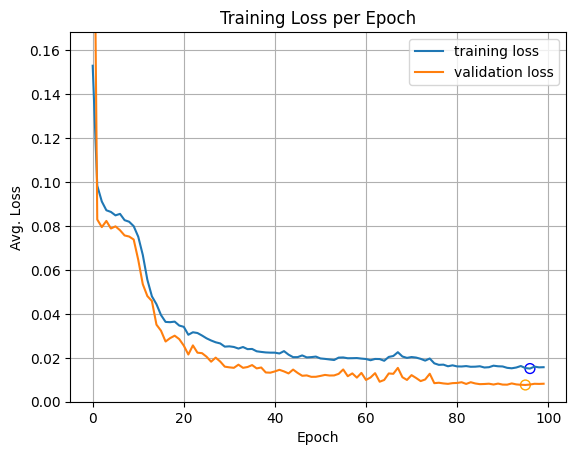

Min epoch loss: 0.015109312381934036
Min validation loss: 0.007626447981844346


In [158]:
# Find index and value of min epoch loss
min_epoch_idx = epoch_losses.index(min(epoch_losses))
min_epoch_val = epoch_losses[min_epoch_idx]

# Find index and value of min validation loss
min_val_idx = val_losses.index(min(val_losses))
min_val_val = val_losses[min_val_idx]

# Plot the losses
plt.plot(epoch_losses, label="training loss")
plt.plot(val_losses, label="validation loss")

# Labels and formatting
plt.xlabel("Epoch")
plt.ylabel("Avg. Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.ylim(0, max(epoch_losses) * 1.1)
plt.legend()

# Highlight min points with circles
plt.scatter(min_epoch_idx, min_epoch_val, facecolors='none', edgecolors='blue', s=50, label='min train loss')
plt.scatter(min_val_idx, min_val_val, facecolors='none', edgecolors='orange', s=50, label='min val loss')

# Annotate values
#plt.text(min_epoch_idx, min_epoch_val*1.0, f"{min_epoch_val:.5f}", color='blue')
#plt.text(min_val_idx, min_val_val*1.0, f"{min_val_val:.5f}", color='orange')


plt.show()

print("Min epoch loss:", min_epoch_val)
print("Min validation loss:", min_val_val)

# Visualize Training Data Results

In [114]:
model_name_best_val

'keypoints_model_3.0.pt'

In [115]:
net.load_state_dict(torch.load(model_dir+model_name_best_val))
net.eval();

In [116]:
batch_size = 10

vis_loader = DataLoader(transformed_dataset, 
                        batch_size=batch_size,
                        shuffle=True, 
                        num_workers=16)

In [117]:
def net_sample_output_train():
    
    # iterate through the test dataset
    for i, sample in enumerate(vis_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].to(device)
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [118]:
train_images, train_outputs, gt_pts = net_sample_output_train()

print(train_images.data.size())
print(train_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


Left: true keypoints. Right: predicted keypoints


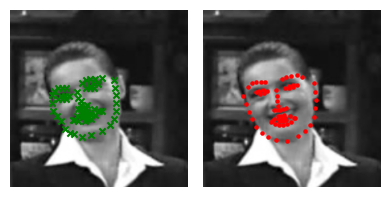

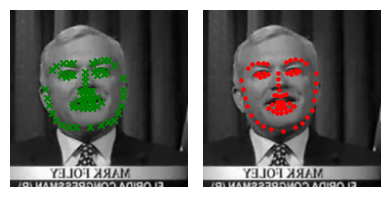

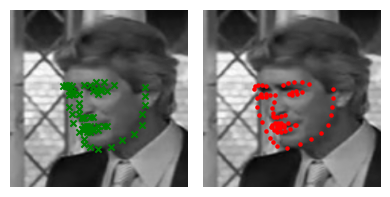

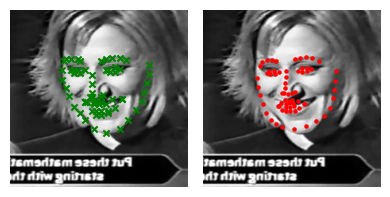

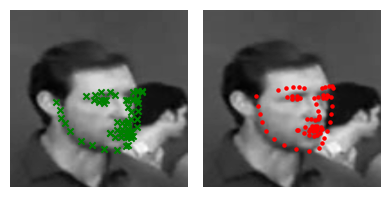

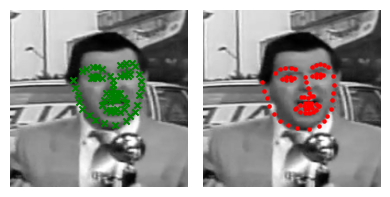

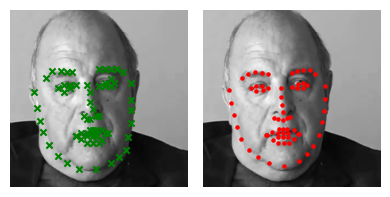

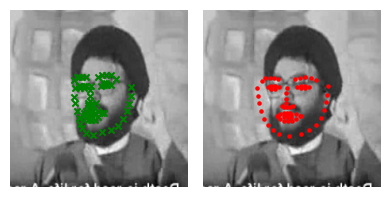

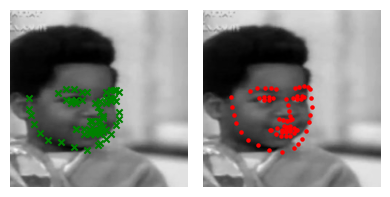

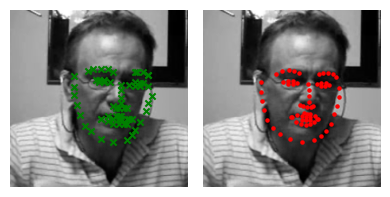

In [119]:
def visualize_output(images, outputs, gt_pts=None, batch_size=10):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    for i in range(batch_size):
        fig, axs = plt.subplots(1, 2, figsize=(4, 4))  # Two subplots per sample (original + keypoints)

        # Un-transform the image
        image = images[i].data
        image = image.cpu().numpy()
        image = np.transpose(image, (1, 2, 0))  # CxHxW -> HxWxC
        image = np.squeeze(image)

        # Un-transform predicted keypoints
        predicted_key_pts = outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # Ground truth
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts.cpu().numpy()
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # Plot original image
        axs[0].imshow(image, cmap='gray')
        if ground_truth_pts is not None:
            axs[0].scatter(ground_truth_pts[:, 0], ground_truth_pts[:, 1], s=20, marker='x', c='g', label='Ground Truth')
        #axs[0].set_title("Input Image")
        axs[0].axis('off')

        # Plot keypoints on image
        axs[1].imshow(image, cmap='gray')
        axs[1].scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='r', label='Predicted')
        
        #axs[1].legend()
        #axs[1].set_title("Predicted Keypoints")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
        #print(predicted_key_pts[:, 0])

    
# train_images ... images from train data loader
# train_output ... predicted keypoints from net_sample_output_train()
# gt_pts ... ground truth keypoints
print("Left: true keypoints. Right: predicted keypoints")
visualize_output(train_images, train_outputs, gt_pts, batch_size)

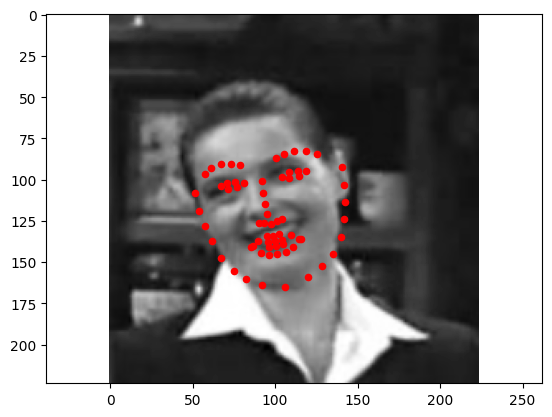

In [128]:
import cv2
from matplotlib import pyplot as plt

def predict_and_show(image):
    image = image.cpu().squeeze()

    resized = image
    resized = np.expand_dims(resized, axis=0)
    tensor = torch.from_numpy(resized).unsqueeze(0).float()

    net.eval()
    with torch.no_grad():
        tensor = tensor.to(device)  
        output_pts = net(tensor)
        output_pts = output_pts.view(1, 68, 2)
        keypoints = output_pts.cpu().numpy().squeeze()
        keypoints = keypoints * 50.0 + 100

    plt.imshow(resized.squeeze(), cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='r')
    plt.axis('equal')
    #plt.title(image_path)
    plt.show()

predict_and_show(train_images[0])

normalizing value range to [0,1]


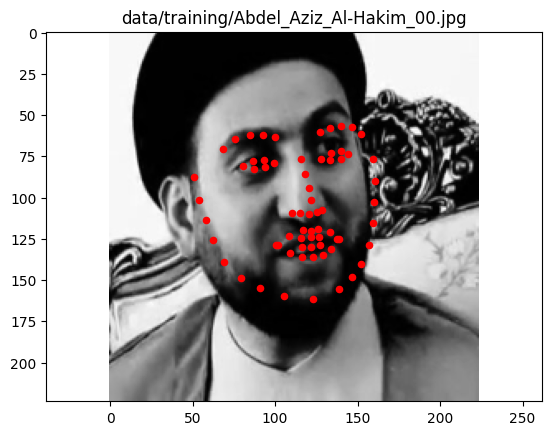

normalizing value range to [0,1]


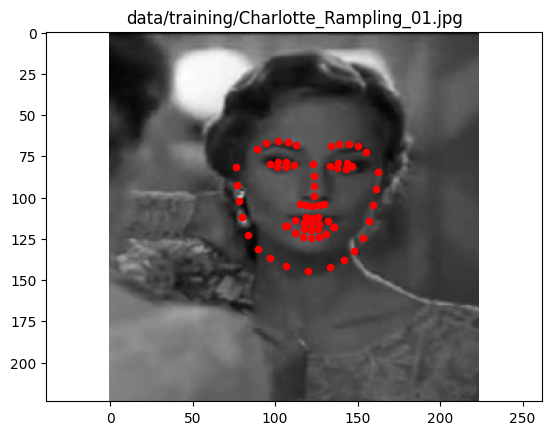

In [135]:
from matplotlib import pyplot as plt

def predict_and_show(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if gray.dtype == np.uint8 or gray.max() > 1.0:
        print('normalizing value range to [0,1]')
        gray = gray / 255.0

    resized = cv2.resize(gray, (224, 224))
    resized = np.expand_dims(resized, axis=0)
    tensor = torch.from_numpy(resized).unsqueeze(0).float()

    net.eval()
    with torch.no_grad():
        tensor = tensor.to(device)  
        output_pts = net(tensor)
        output_pts = output_pts.view(1, 68, 2)
        keypoints = output_pts.cpu().numpy().squeeze()
        keypoints = keypoints * 50.0 + 100

    plt.imshow(resized.squeeze(), cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='r')
    plt.axis('equal')
    plt.title(image_path)
    plt.show()

# Try two distinct images
predict_and_show('data/training/Abdel_Aziz_Al-Hakim_00.jpg')#predict_and_show('images/mona_lisa.jpg')
predict_and_show('data/training/Charlotte_Rampling_01.jpg')

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [136]:
model_name_best_val

'keypoints_model_3.0.pt'

In [137]:
#model_name_epoch = 'keypoints_model_1_epoch_best.pt'
#model_name_batch = 'keypoints_model_1_batch_best.pt'

#net.load_state_dict(torch.load(model_dir+model_name_batch))
net.load_state_dict(torch.load(model_dir+model_name_best_val))
net.eval();

In [138]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [139]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

#visualize_output(test_images, test_outputs, gt_pts)


Left: true keypoints. Right: predicted keypoints


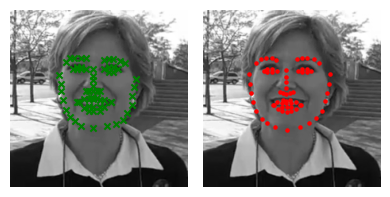

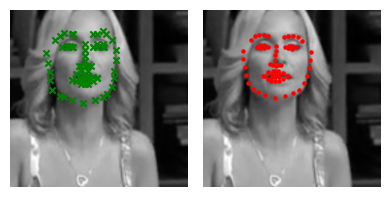

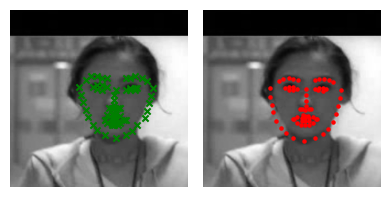

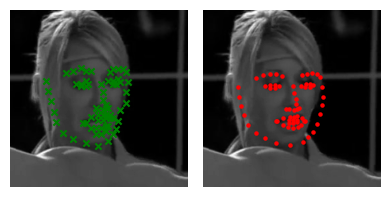

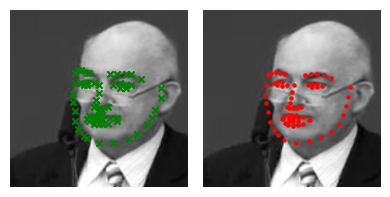

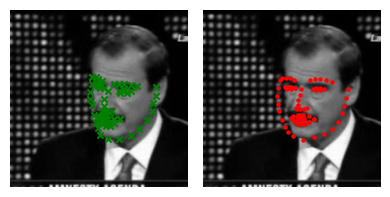

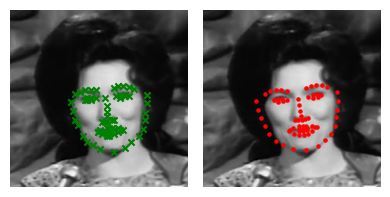

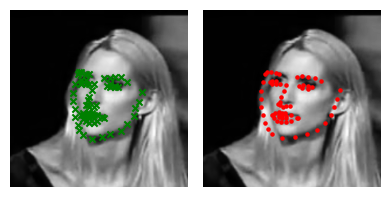

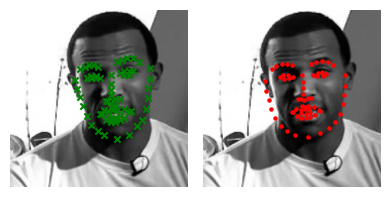

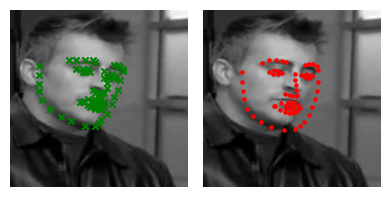

In [140]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    for i in range(batch_size):
        fig, axs = plt.subplots(1, 2, figsize=(4, 4))  # Two subplots per sample (original + keypoints)

        # Un-transform the image
        image = test_images[i].data
        image = image.cpu().numpy()
        image = np.transpose(image, (1, 2, 0))  # CxHxW -> HxWxC
        image = np.squeeze(image)

        # Un-transform predicted keypoints
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # Ground truth
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts.cpu().numpy()
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # Plot original image
        axs[0].imshow(image, cmap='gray')
        if ground_truth_pts is not None:
            axs[0].scatter(ground_truth_pts[:, 0], ground_truth_pts[:, 1], s=20, marker='x', c='g', label='Ground Truth')
        #axs[0].set_title("Input Image")
        axs[0].axis('off')

        # Plot keypoints on image
        axs[1].imshow(image, cmap='gray')
        axs[1].scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='r', label='Predicted')
        
        #axs[1].legend()
        #axs[1].set_title("Predicted Keypoints")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    
# call it
print("Left: true keypoints. Right: predicted keypoints")
visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [141]:
#model_dir = 'saved_models/'
#model_name = 'keypoints_model_2.0_final.pt'

# after training, save your model parameters in the dir 'saved_models'
#torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?



**I tried the Adam solver and the SGD solver, but in the end I used the Adam solver because it provided good results after tweaking the learn rate.** 

**I tried MSELoss and L1Loss, but settled for MSELoss because I made sure that there a no outliers in the data and there is no need for L1Loss.** 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**I started with an architecture very similar to the NaimishNet, and then added an additional convolutional layer. I also optimized the kernel sizes in the various layers and added padding. I also reduced the number of nodes in the fully connected layers to prevent over-fitting.**

**Adding a sixth convolutional layer did not improve the performance.**

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**I found out that a batch size of 64 is a good trade-off between training speed and noise in the gradient.**

**I could get improvements in the validation loss until around epoch 100, so I used this as the limit for training.** 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.20873886 -0.4086242  -0.52768916 -0.41222945 -0.15997766 -0.30743888
  -0.33406857]
 [-0.22381054 -0.40055618 -0.34940994 -0.2509741  -0.20419873 -0.17503853
  -0.0758478 ]
 [ 0.11546525 -0.13042784 -0.17002256  0.07831173  0.0675373   0.06029051
  -0.19615164]
 [ 0.21828586  0.25877947  0.12322857  0.11908525  0.15970258  0.09664709
  -0.04681918]
 [ 0.27648544  0.34899163  0.33282375  0.1154272   0.10748598 -0.02857508
   0.10511933]
 [ 0.32631055  0.13867901  0.35907733  0.25334138  0.01357412 -0.00787996
   0.06421722]
 [ 0.23809794  0.30983976  0.17745103  0.09735537  0.20645697 -0.01786964
   0.1209882 ]]
(7, 7)


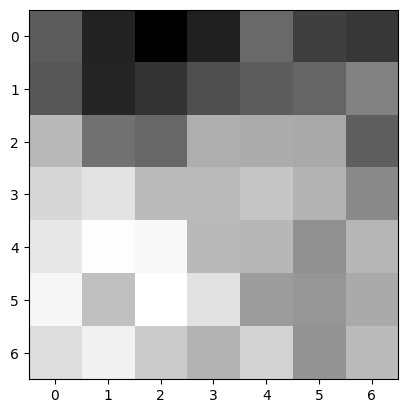

In [142]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in its convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### Filter an image to see the effect of a convolutional kernel
---

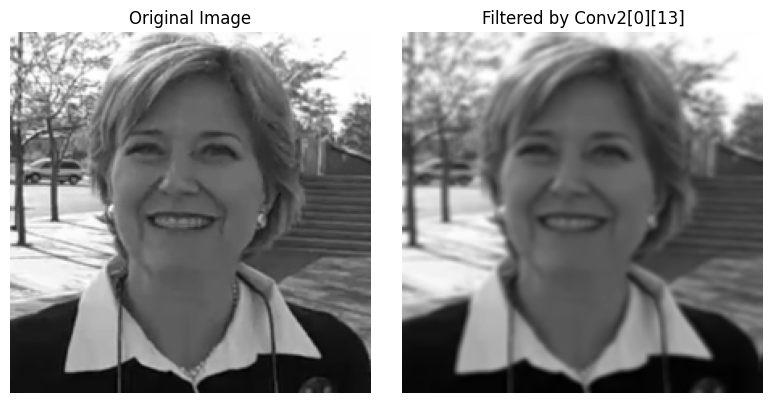

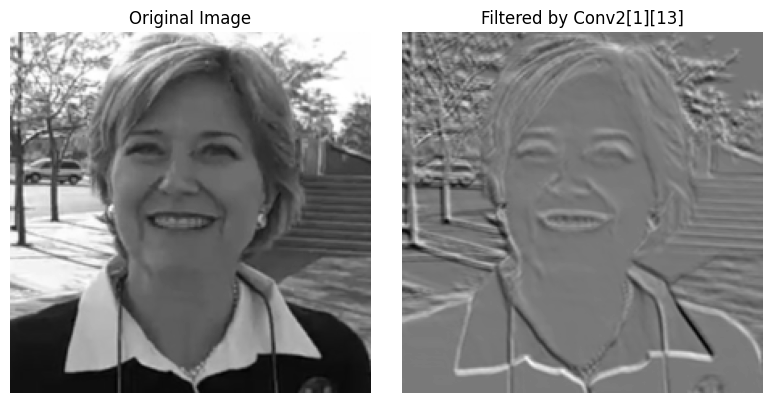

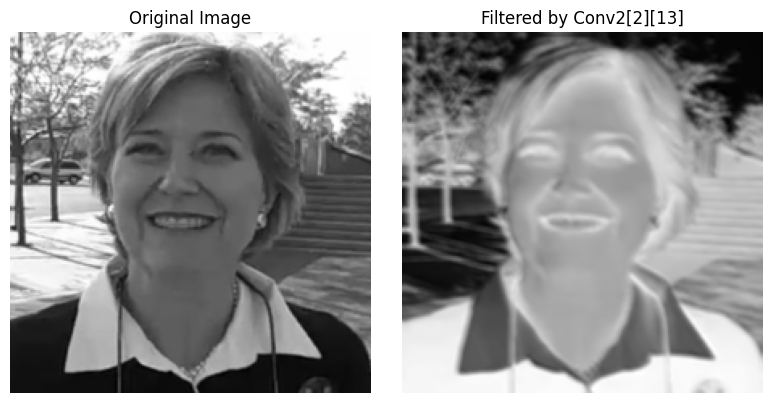

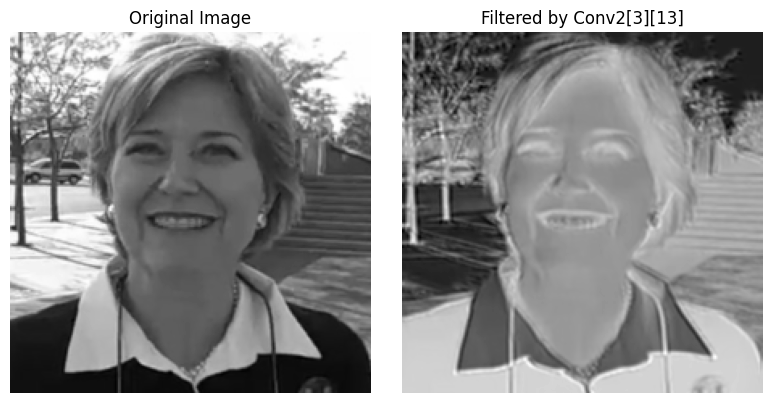

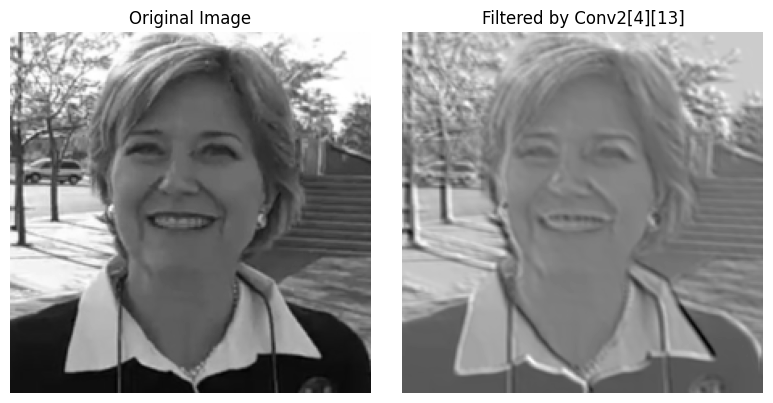

In [157]:
def visualize_output(test_images, batch_size=10, net=None, filter_indices=[0, 1, 2, 3, 4]):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import cv2

    n_samples = min(batch_size, len(test_images))
    
    if net is None:
        print("Model (net) is required to extract filters.")
        return

    # Extract conv2 weights: shape (out_channels, in_channels, H, W)
    conv2_weights = net.conv2.weight.data.cpu().numpy()

    for i in range(n_samples):
        # Untransform image
        image = test_images[i].data.cpu().numpy()
        image = np.transpose(image, (1, 2, 0))  # CxHxW -> HxWxC
        image = np.squeeze(image)  # Grayscale (HxW)

        for filter_index in filter_indices:
            input_channel = 13
            conv2_filter = conv2_weights[filter_index, input_channel, :, :]

            fig, axs = plt.subplots(1, 2, figsize=(8, 4))

            # Original image
            axs[0].imshow(image, cmap='gray')
            axs[0].set_title("Original Image")
            axs[0].axis('off')

            # Filtered image
            image_for_filter = image if image.ndim == 2 else image[:, :, 0]
            filtered = cv2.filter2D(src=image_for_filter, ddepth=-1, kernel=conv2_filter)
            axs[1].imshow(filtered, cmap='gray')
            axs[1].set_title(f"Filtered by Conv2[{filter_index}][{input_channel}]")
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()

visualize_output(test_images, batch_size=1, net=net, filter_indices=[0, 1, 2, 3, 4])

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**It looks like the filter from the first convolutionsl layer (Filtered by Conv2[0][0]) has a smoothing / averaging effect, which would commonly be used in computer vision to reduce noise.**  

**The filter from the second convolutionsl layer (Filtered by Conv2[1][0]) seems to be some sort of gradient detectior.**  

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!